In [1]:
import os
import torch
from torch import Tensor
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn.functional as F
from matplotlib import pyplot as plt
from dataset1 import SketchDataset
from nodediff_model import GD3PM, CosineNoiseScheduler
# from gumbel_diffusion_model import GD3PM, CosineNoiseScheduler
from model2 import GVAE
from sampler_trainer import Sampler
from utils import BoundingBoxShiftScale, ToIscosceles, ToNaive
import pandas as pd
from collections import OrderedDict
from tqdm import tqdm

import sketchgraphs.data as datalib
import sketchgraphs.onshape.call as onshape_call

import urllib.parse
import requests
import json

# Create a new OrderedDict without the 'module.' prefix
def DDP_to_normal(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # Remove 'module.'
        new_state_dict[name] = v

    return new_state_dict

# Freeze model parameters
def freeze_model(model):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

import math
def PredsToJSON(nodes : torch.Tensor, edges : torch.Tensor):
    primitives = []
    constraints = []
    # Add entities
    for idx in range(len(nodes)):
        entity = nodes[idx]
        id = "p" + str(idx)
        isConstructible = bool(entity[0].item() >= 0.5)
        match torch.argmax(entity[1:6]):
            case 0:
                # Create Line
                pnt = entity[6:8]
                startParam = 0
                dir = (entity[8:10] - entity[6:8]) / torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                endParam = torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                line = {
                    "btType": "BTMSketchCurveSegment-155",
                    "startParam": startParam,
                    "endParam": endParam.item(),
                    "geometry": {
                    "btType": "BTCurveGeometryLine-117",
                    "pntX": pnt[0].item(),
                    "pntY": pnt[1].item(),
                    "dirX": dir[0].item(),
                    "dirY": dir[1].item()
                    },
                    "startPointId": id + ".start",
                    "endPointId": id + ".end",
                    "entityId": id,
                    "isConstruction": isConstructible
                }
                primitives.append(line)
            case 1:
                # Create Circle
                center = entity[10:12]
                radius = entity[12]
                circle = {
                    "btType": "BTMSketchCurve-4",
                    "geometry": {
                    "btType": "BTCurveGeometryCircle-115",
                    "radius": radius.item(),  
                    "xCenter": center[0].item(),
                    "yCenter": center[1].item(),  
                    "xDir": 1,
                    "yDir": 0, 
                    "clockwise": False 
                    },
                    "centerId": id + ".center",
                    "entityId": id,
                    "isConstruction": isConstructible
                }
                primitives.append(circle)
            case 2: 
                # Create Arc
                center = entity[13:15]
                radius = entity[15]
                startParam = entity[16] * (2*math.pi)
                endParam = entity[17] * (2*math.pi)
                arc = {
                    "btType": "BTMSketchCurveSegment-155",
                    "startParam": startParam.item(),
                    "endParam": endParam.item(),
                    "geometry": {
                    "btType": "BTCurveGeometryCircle-115",
                    "radius": radius.item(),  
                    "xCenter": center[0].item(),
                    "yCenter": center[1].item(),  
                    "xDir": 1,
                    "yDir": 0, 
                    "clockwise": False 
                    },
                    "startPointId": id + ".start",
                    "endPointId": id + ".end",
                    "centerId": id + ".center",
                    "entityId": id,
                    "isConstruction": isConstructible
                }
                primitives.append(arc)
            case 3:
                # Create Point
                x = entity[18]
                y = entity[19]
                point = {
                    "btType": "BTMSketchPoint-158",
                    "x": x.item(),
                    "y": y.item(),
                    "isConstruction": isConstructible,
                    "entityId": id
                }
                primitives.append(point)
            case _:
                continue

    # Add constraints
    idx = 0
    constraint_types = ["COINCIDENT", "HORIZONTAL", "VERTICAL", "PARALLEL", "PERPENDICULAR", "TANGENT", "MIDPOINT", "EQUAL", "NONE"]
    subprimitive_references = [".start", ".center", ".end", ""] # If the subprimitive reference is None, then the constraint references the whole primitive
    for i in range(edges.size(0)):
        for j in range(edges.size(1)):
            # if i == 2 and j == 3:
            #     x = 5
            constraint = edges[i][j]
            # Extract Constraint Type
            constraintType = constraint_types[torch.argmax(constraint[8:17]).item()]
            if constraintType == "NONE": continue # Skip current loop iteration

            param_ids = ["localFirst", "localSecond"]
            # Adjust reference parameter ids if necessary
            if constraintType == "MIDPOINT": 
                param_ids = ["localEntity1", "localEntity2"]
            
            # Fill constraint parameters
            params = []
            if i == j:
                # Constraint only applies to single entity
                node_ref = "p" + str(i) + subprimitive_references[torch.argmax(constraint[0:4]).item()]
                param1 = {
                    "btType": "BTMParameterString-149",
                    "value": node_ref,
                    "parameterId": param_ids[0]
                }
                params.append(param1)
            else:
                # Constraint applies to 2 primitives
                node_a_ref = "p" + str(i) + subprimitive_references[torch.argmax(constraint[0:4]).item()]
                param1 = {
                    "btType": "BTMParameterString-149",
                    "value": node_a_ref,
                    "parameterId": param_ids[0]
                }
                params.append(param1)

                node_b_ref = "p" + str(j) + subprimitive_references[torch.argmax(constraint[4:8]).item()]
                param2 = {
                    "btType": "BTMParameterString-149",
                    "value": node_b_ref,
                    "parameterId": param_ids[1]
                }
                params.append(param2)
            
            # Add constraint JSON
            id = "c_" + str(idx)
            constraints.append({
                "btType": "BTMSketchConstraint-2",
                "constraintType": constraintType,
                "parameters": params,
                'entityId': id
            })
            idx = idx + 1

    payload = {
        "feature" : {
        "btType": "BTMSketch-151", 
        "featureType": "newSketch", 
        "name": "Sketch 1", 
        "parameters": [
        {
            "btType": "BTMParameterQueryList-148",
            "queries": [
            {
                "btType": "BTMIndividualQuery-138",
                "queryString": "query=qCreatedBy(makeId(\"Front\"), EntityType.FACE);"
            }
            ],
            "parameterId": "sketchPlane" 
        }
        ],
        "entities": primitives,
        "constraints": constraints
        }
    }
    return payload

def send_to_onshape(nodes, edges):
    url = R'https://cad.onshape.com/documents/ea3676f6eae5d981536d8aa0/w/b3c060a59b0d90358e9904cf/e/c73b7a827e9d662d32f2f6b3'
    access_key = "CiR9Ot162KLFIjy4X5685DCH"
    secret_key = "MRgWejgCDpru5J11mp0Uk5whGC7dFWrjgTUTlWSzzxvwTwXg"

    _, _, docid, _, wid, _, eid = urllib.parse.urlparse(url).path.split('/')

    r = requests.post(url = f"https://cad.onshape.com/api/v9/partstudios/d/{docid}/w/{wid}/e/{eid}/features", auth = (access_key, secret_key), json = PredsToJSON(nodes, edges))

    # r.text

    # r = requests.get(url = f"https://cad.onshape.com/api/v9/partstudios/d/{docid}/w/{wid}/e/{eid}/features", auth = (access_key, secret_key))

    # data = r.json()
    # data['features'][0]['constraints']
    return r.json()

In [2]:
GPU = 7
OUTPUT_DIR = "evaluation_outputs/"

# Diffusion Model

In [3]:
nodes = torch.load("data/processed/nodes2.pt")
# Scale and Shift to normalize data
nodes = ToIscosceles(BoundingBoxShiftScale(nodes))
# Add not constructible category
nodes = torch.cat([1 - nodes[...,[0]], nodes], dim = -1)

params_mask = torch.load("data/processed/node_params_mask2.pt")
edges = torch.load("data/processed/edges2.pt")

dataset = TensorDataset(nodes, edges, params_mask)
train_set, validate_set, test_set = random_split(dataset = dataset, lengths = [0.9, 0.05, 0.05], generator = torch.Generator().manual_seed(4))

In [4]:
diff_model = GD3PM(GPU)
# state_dict = torch.load("checkpoint_nodesoftgaussdiff_ddp_adam_32layers_512nodedim_512condim_16heads.pth", map_location = {'cuda:%d' % 0: 'cuda:%d' % 7})["model"]
# diff_state_dict = torch.load("checkpoint_softgaussdiff_ddp_adam_constenf_24layers_512nodedim_256condim_256edgedim_8heads.pth", map_location = {'cuda:%d' % 0: 'cuda:%d' % 7})["model"]
# diff_state_dict = torch.load("checkpoint_softgaussdiff_ddp_adam_dropout_48layers_512nodedim_256condim_8heads_best.pth", map_location = {'cuda:%d' % 0: 'cuda:%d' % 7})["model"]
diff_state_dict = torch.load("checkpoint_nodediff_ddp_adam_nopos_32layers_512nodedim_512condim_8heads_2000denoisingsteps.pth", map_location = {'cuda:%d' % 0: 'cuda:%d' % 7})["model"]

diff_model.load_state_dict(DDP_to_normal(diff_state_dict))
freeze_model(diff_model)

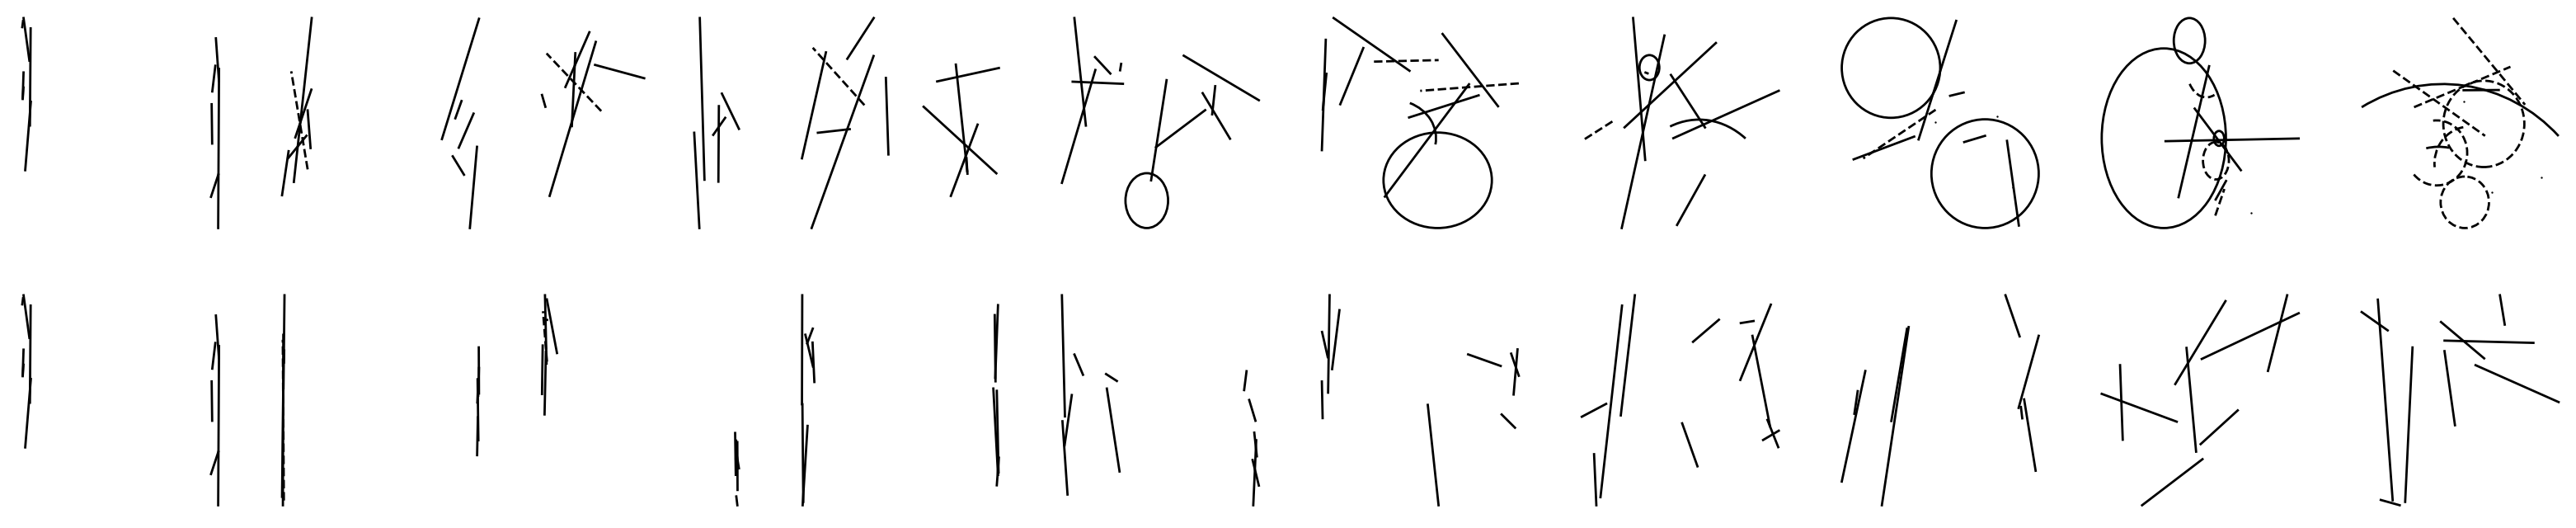

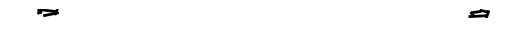

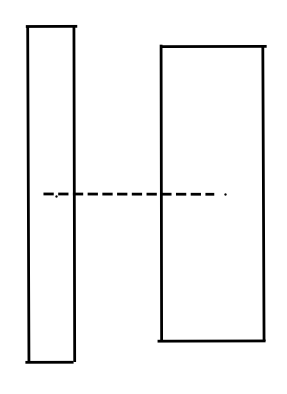

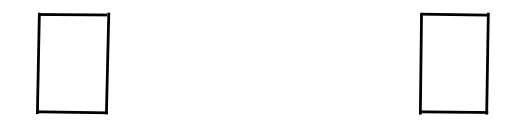

In [5]:
with torch.no_grad():
    node_seed, edge_seed = diff_model.noise_scheduler.sample_latent(4)
    fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize=(40, 8))
    sampled_nodes, sampled_edges = diff_model.denoise(node_seed, edge_seed, axes)
    sampled_nodes = ToNaive(sampled_nodes[...,1:]) # Remove not constructible category and switch to naive arc parameterization
    for i in range(sampled_nodes.size(0)):
        # fig = plt.figure()
        # ax = fig.add_subplot(111, aspect='equal')
        SketchDataset.render_graph(sampled_nodes[i].cpu(), sampled_edges[i].cpu())
        # plt.savefig(f"evaluation_outputs/diff_samples/diff_{i}.png")
        # plt.close(fig)

In [8]:
idx = 3
send_to_onshape(sampled_nodes[idx], sampled_edges[idx])
# temp = torch.zeros(16,16,17)
# temp[...,16] = 1
# send_to_onshape(sampled_nodes[idx], temp)

{'btType': 'BTFeatureDefinitionResponse-1617',
 'featureState': {'btType': 'BTFeatureState-1688',
  'featureStatus': 'OK',
  'inactive': False},
 'feature': {'btType': 'BTMSketch-151',
  'constraints': [{'btType': 'BTMSketchConstraint-2',
    'hasOffsetData1': False,
    'offsetOrientation1': False,
    'offsetDistance1': 0.0,
    'hasOffsetData2': False,
    'offsetOrientation2': False,
    'offsetDistance2': 0.0,
    'hasPierceParameter': False,
    'pierceParameter': 0.0,
    'helpParameters': [],
    'constraintType': 'PARALLEL',
    'parameters': [{'btType': 'BTMParameterString-149',
      'value': 'p0',
      'nodeId': 'M/MUOO/a0xNINmkVD',
      'parameterId': 'localFirst'},
     {'btType': 'BTMParameterString-149',
      'value': 'p1',
      'nodeId': 'MFTNez2mzMTNIjdOa',
      'parameterId': 'localSecond'}],
    'namespace': '',
    'nodeId': 'MRCt/IAXwAxsm8TFB',
    'index': 1,
    'entityId': 'c_0'},
   {'btType': 'BTMSketchConstraint-2',
    'hasOffsetData1': False,
    'off

Log Likelihood

In [7]:
def near_one_hot(tensor : Tensor, k):
        return k * tensor + (1 - k) / tensor.size(-1)

def nll_scale(a_bar, prev_a_bar):
        # a = a_bar / prev_a_bar
        # return 0.5 * (1 - a) * (prev_a_bar) / ((1 - prev_a_bar.sqrt()) * (1 - a_bar))
        return 0.5 * (prev_a_bar / (1 - prev_a_bar) - a_bar / (1 - a_bar))

def diffusion_elbo(pred_nodes : Tensor, true_nodes : Tensor, pred_edges : Tensor, true_edges : Tensor, params_mask : Tensor, t, scheduler : CosineNoiseScheduler):
        # scales = nll_scale(scheduler.a_bar[t], scheduler.a_bar[t - 1])
        
        subnode_var = nll_scale(scheduler.continous_variance_to_discrete_variance(scheduler.a_bar[t], 4), scheduler.continous_variance_to_discrete_variance(scheduler.a_bar[t - 1], 4))
        subnode_var = subnode_var.unsqueeze(-1).unsqueeze(1).unsqueeze(1)
        edge_elbo  = torch.sum(subnode_var * (pred_edges[...,0:4] - true_edges[...,0:4]) ** 2)
        edge_elbo += torch.sum(subnode_var * (pred_edges[...,4:8] - true_edges[...,4:8]) ** 2)

        constraint_var = nll_scale(scheduler.continous_variance_to_discrete_variance(scheduler.a_bar[t], 9), scheduler.continous_variance_to_discrete_variance(scheduler.a_bar[t - 1], 9))
        constraint_var = constraint_var.unsqueeze(-1).unsqueeze(1).unsqueeze(1)
        edge_elbo += torch.sum(constraint_var * (pred_edges[...,8:] - true_edges[...,8:]) ** 2)

        # edge_scales = torch.cat([subnode_var, subnode_var, constraint_var], dim = -1).unsqueeze(1).unsqueeze(1)
        # edge_elbo = torch.sum(edge_scales * (pred_edges - true_edges) ** 2)
        
        constructible_var = nll_scale(scheduler.continous_variance_to_discrete_variance(scheduler.a_bar[t], 2), scheduler.continous_variance_to_discrete_variance(scheduler.a_bar[t - 1], 2))
        constructible_var = constructible_var.unsqueeze(-1).unsqueeze(1)
        node_elbo = torch.sum(constructible_var * (pred_nodes[...,0:2] - true_nodes[...,0:2]) ** 2)

        primitive_var = nll_scale(scheduler.continous_variance_to_discrete_variance(scheduler.a_bar[t], 5), scheduler.continous_variance_to_discrete_variance(scheduler.a_bar[t - 1], 5))
        primitive_var = primitive_var.unsqueeze(-1).unsqueeze(1)
        node_elbo += torch.sum(primitive_var * (pred_nodes[...,2:7] - true_nodes[...,2:7]) ** 2)

        parameter_var = nll_scale(scheduler.a_bar[t], scheduler.a_bar[t - 1])
        parameter_var = parameter_var.unsqueeze(-1).unsqueeze(1)
        node_elbo += torch.sum(parameter_var * params_mask * (pred_nodes[...,7:] - true_nodes[...,7:]) ** 2)

        # node_scales = torch.cat([constructible_var, primitive_var, parameter_var], dim = -1).unsqueeze(1)
        # pred_nodes[...,7:] = pred_nodes[...,7:] * params_mask

        return node_elbo, edge_elbo

In [8]:
test_loader = DataLoader(dataset = test_set, batch_size = 512)
node_nll = 0
edge_nll = 0
# i = 0

with torch.no_grad():
    pbar = tqdm(test_loader)
    for nodes, edges, params_mask in pbar:
        # nodes = nodes.expand(diff_model.max_timestep - 1, -1, -1).to(GPU)
        # edges = edges.expand(diff_model.max_timestep - 1, -1, -1, -1).to(GPU)
        # params_mask = params_mask.expand(diff_model.max_timestep - 1, -1, -1).to(GPU)
        nodes = nodes.to(GPU)
        edges = edges.to(GPU)
        params_mask = params_mask.to(GPU)

        t = torch.randint(low = 1, high = diff_model.max_timestep, size = (nodes.size(0),)).to(GPU)
        # t = torch.arange(1, diff_model.max_timestep, 1).to(GPU)
        noised_nodes, noised_edges = diff_model.noise_scheduler(nodes, edges, t)

        pred_nodes, pred_edges = diff_model(noised_nodes, noised_edges, t)

        # nodes[...,0:2] = near_one_hot(nodes[...,0:2], diff_model.noise_scheduler.min_k)
        # nodes[...,2:7] = near_one_hot(nodes[...,2:7], diff_model.noise_scheduler.min_k)
        # edges[...,0:4] = near_one_hot(edges[...,0:4], diff_model.noise_scheduler.min_k)
        # edges[...,4:8] = near_one_hot(edges[...,4:8], diff_model.noise_scheduler.min_k)
        # edges[...,8: ] = near_one_hot(edges[...,8: ], diff_model.noise_scheduler.min_k)

        node_elbo, edge_elbo = diffusion_elbo(pred_nodes, nodes, pred_edges, edges, params_mask, t, diff_model.noise_scheduler)

        node_nll += node_elbo * diff_model.max_timestep
        edge_nll += edge_elbo * diff_model.max_timestep

        # i += nodes.size(0)
        # pbar.set_description(f"NLL: {(node_nll + edge_nll) / i}")
        # if i == 50000: break
    
    node_nll = node_nll / len(test_set)
    edge_nll = edge_nll / len(test_set)
    print(node_nll / math.log(2), edge_nll / math.log(2))

    

100%|██████████| 140/140 [00:32<00:00,  4.27it/s]

tensor(106.0973, device='cuda:7')


# VAE

In [3]:
nodes = torch.load("data/processed/nodes2.pt")
# Scale and Shift to normalize data
nodes = BoundingBoxShiftScale(nodes)

params_mask = torch.load("data/processed/node_params_mask2.pt")
edges = torch.load("data/processed/edges2.pt")

dataset = TensorDataset(nodes, edges, params_mask)
train_set, validate_set, test_set = random_split(dataset = dataset, lengths = [0.9, 0.05, 0.05], generator = torch.Generator().manual_seed(4))

In [33]:
sampler = Sampler(GPU)
vae = GVAE(GPU)

# Load the original saved file with DataParallel
sampler_state_dict = torch.load('checkpoints/model_checkpoint_sampler_ddp_Adam_depth_32_1.pth')
vae_state_dict = torch.load('checkpoints/model_checkpoint_gvae_ddp_Adam_mse-25_kld-.001_16layers16heads256hiddenencoder_16layers16heads256hiddendecoder_embedim1024_tempnodedim128_relu_after_node_layernorm.pth')
# vae_state_dict = torch.load('model_checkpoint_gvae_ddp_Adam_12enclayers_12declayers.pth')
# sharpener_state_dict = torch.load('model_checkpoint_sharpener_ddp_Adam_16tflayers.pth')


# Load the parameters into your model and freeze
sampler.load_state_dict(DDP_to_normal(sampler_state_dict))
vae.load_state_dict(DDP_to_normal(vae_state_dict))

freeze_model(sampler)
freeze_model(vae)

In [34]:
T = sampler.max_timestep
a_bar = torch.cos(0.5 * torch.pi * (torch.arange(0.0, 1.0, 1/(T + 1)) + .008) / 1.008) ** 2
a_bar = a_bar / a_bar[0]
a_bar = a_bar.to(GPU)

a = a_bar[1:] / a_bar[:-1]
a = torch.cat([a, torch.tensor([0.0]).to(GPU)])

sqrt_a = a.sqrt()
sqrt_a_bar = a_bar.sqrt().to(GPU)
sqrt_b_bar = (1 - a_bar).sqrt().to(GPU)

sqrt_post_var = torch.cat([torch.tensor([0.0]).to(GPU), (a_bar[:-1] / a_bar[1:] * (1 - a[1:]))]).sqrt()

def sample_latent(batch_size):
    sampled_latents = torch.randn((batch_size, 1024)).to(GPU)

    for i in reversed(range(1, sampler.max_timestep)):
        pred_latents = sampler(sampled_latents, torch.full(size = (batch_size,), fill_value = i).to(GPU))
      
        denoised_mean = (sqrt_a_bar[i - 1] * (1 - a[i]) * pred_latents + sqrt_a[i] * (1 - a_bar[i - 1]) * sampled_latents) / (1 - a_bar[i])
        if i > 1:
            sampled_latents = denoised_mean + sqrt_post_var[i] * torch.randn_like(denoised_mean)
        else:
            sampled_latents = denoised_mean
    
    return sampled_latents

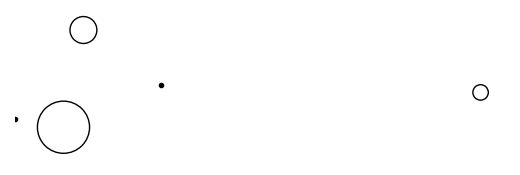

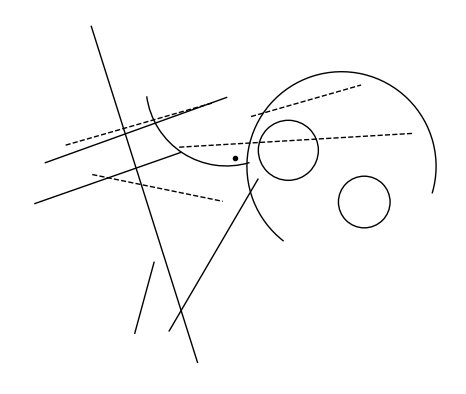

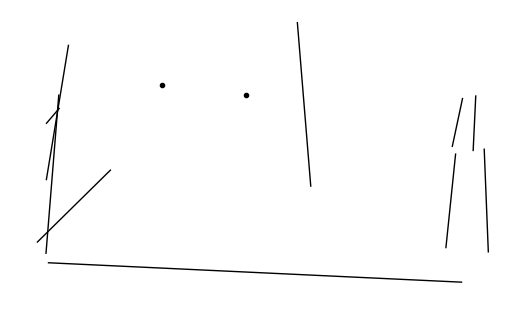

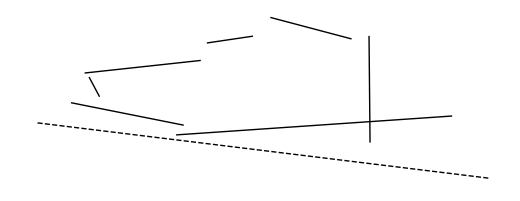

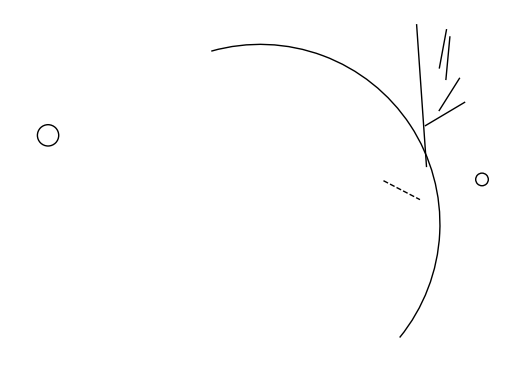

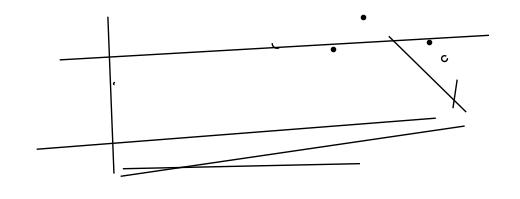

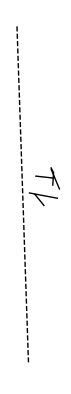

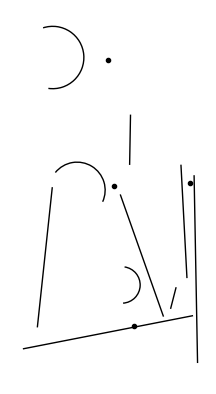

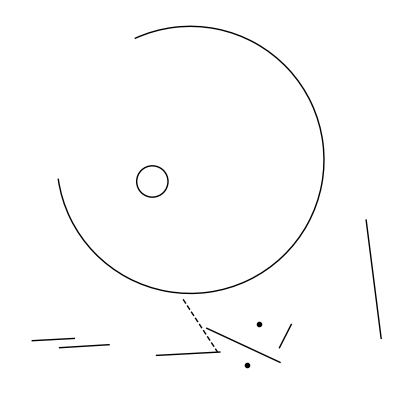

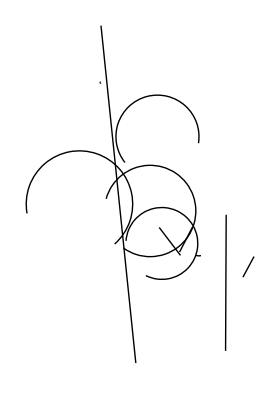

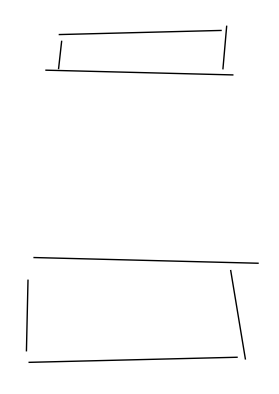

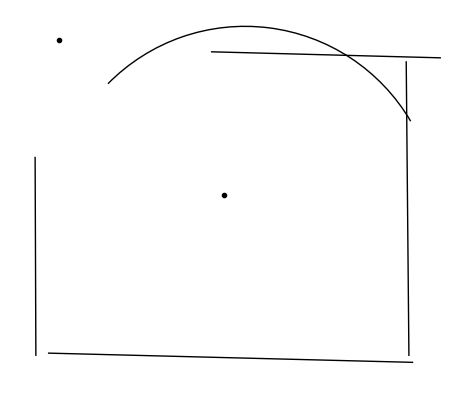

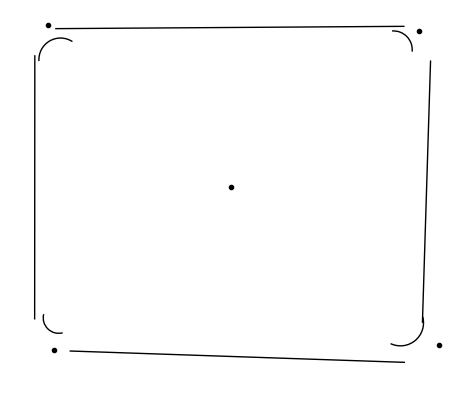

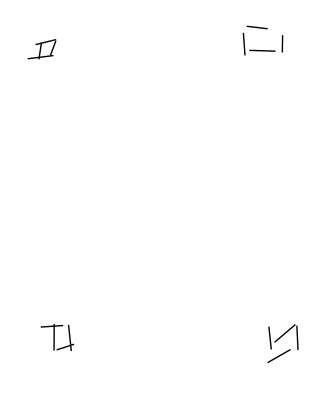

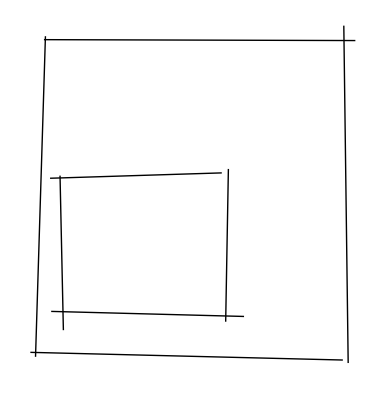

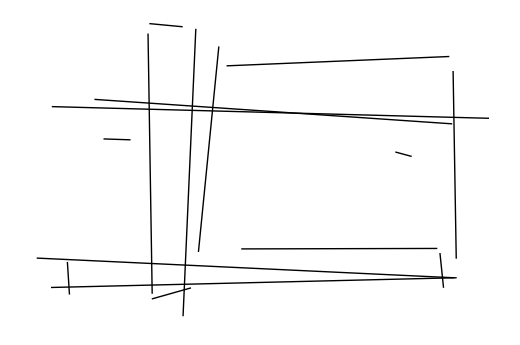

In [35]:
with torch.no_grad():
    latents = sample_latent(16)
    decoded_nodes, decoded_edges = vae.decoder(latents)
    for i in range(decoded_nodes.size(0)):
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        SketchDataset.render_graph(decoded_nodes[i].cpu(), decoded_edges[i].cpu(), ax)
        plt.savefig(f"evaluation_outputs/vae_samples/vae_{i}.png")


In [ ]:
idx = 0
send_to_onshape(decoded_nodes[idx], decoded_edges[idx])

Likelihood

In [5]:
def compute_vae_nll(
    encoder,
    decoder,
    nodes: torch.Tensor,  # Shape: [batch_size, num_nodes, node_dim]
    edges: torch.Tensor,  # Shape: [batch_size, num_nodes, num_nodes, edge_dim]
    params_mask : Tensor,
    num_samples: int = 100
) -> torch.Tensor:
    """
    Compute negative log likelihood for a graph VAE using importance sampling.
    Optimized version that processes all samples in parallel.
    
    Args:
        encoder: VAE encoder that takes (nodes, edges) and returns (mean, logvar)
        decoder: VAE decoder that takes latent and returns reconstructed (nodes, edges)
        nodes: Input node features [B, N, D_n]
        edges: Input edge features [B, N, N, D_e]
        num_samples: Number of samples for importance sampling
    
    Returns:
        nll: Estimated negative log likelihood per batch
    """
    batch_size = nodes.shape[0]
    device = nodes.device
    
    # Get encoder parameters
    mean, logvar = encoder(nodes, edges)  # [B, latent_dim]
    std = torch.exp(0.5 * logvar)
    
    # Expand dimensions for parallel sampling
    # [B, 1, D] -> [B, K, D] where K is num_samples
    mean_expanded = mean.unsqueeze(1).expand(-1, num_samples, -1)
    std_expanded = std.unsqueeze(1).expand(-1, num_samples, -1)
    
    # Sample all latents at once
    # [B, K, D]
    eps = torch.randn_like(mean_expanded)
    z = mean_expanded + std_expanded * eps
    
    # Reshape for batch processing
    B, K, D = z.shape
    z_flat = z.reshape(B * K, D)
    
    # Repeat input tensors K times
    nodes_repeated = nodes.repeat_interleave(K, dim=0)  # [B*K, N, D_n]
    edges_repeated = edges.repeat_interleave(K, dim=0)  # [B*K, N, N, D_e]
    mask_repeated = params_mask.repeat_interleave(K, dim=0)  # [B*K, N, D_n]
    
    # Decode all samples at once
    nodes_recon, edges_recon = decoder(z_flat)  # [B*K, N, D_n], [B*K, N, N, D_e]
    
    nodes_recon[...,6:] *= mask_repeated
    # Compute reconstruction log probabilities
    log_p_x_given_z_nodes = -0.5 * torch.sum(
        torch.pow(nodes_repeated - nodes_recon, 2), dim=(1, 2)
    )  # [B*K]
    
    log_p_x_given_z_edges = -0.5 * torch.sum(
        torch.pow(edges_repeated - edges_recon, 2), dim=(1, 2, 3)
    )  # [B*K]
    
    # Reshape back to [B, K]
    log_p_x_given_z = (log_p_x_given_z_nodes + log_p_x_given_z_edges).reshape(B, K)
    
    # Prior log probability [B, K]
    log_p_z = -0.5 * torch.sum(torch.pow(z, 2), dim=2)
    
    # Encoder log probability [B, K]
    log_q_z_given_x = -0.5 * torch.sum(
        logvar.unsqueeze(1) + torch.pow(eps, 2), dim=2
    )
    
    # Importance weights [B, K]
    log_w = log_p_x_given_z + log_p_z - log_q_z_given_x
    
    # Log mean exp trick for numerical stability
    log_w_max, _ = torch.max(log_w, dim=1, keepdim=True)
    log_w_normalized = log_w - log_w_max
    
    # Compute final negative log likelihood
    nll = -(log_w_max.squeeze() + torch.log(
        torch.mean(torch.exp(log_w_normalized), dim=1)
    ))
    
    return nll

In [10]:
test_loader = DataLoader(dataset = test_set, batch_size = 1)
node_nll = 0
edge_nll = 0
sketch_nll = 0
i = 0

with torch.no_grad():
    pbar = tqdm(test_loader)
    for nodes, edges, params_mask in pbar:
        nodes = nodes.to(GPU)
        edges = edges.to(GPU)
        params_mask = params_mask.to(GPU)
        # Pad to 24 Nodes and 24 x 24 Edges
        # temp_nodes = torch.zeros(nodes.size(0), 24, 20).to(GPU)
        # temp_nodes[...,5] = 1
        # temp_nodes[:,:16] = nodes.to(GPU)

        # temp_edges = torch.zeros(nodes.size(0), 24, 24, 17).to(GPU)
        # temp_edges[...,[3,7,16]] = 1
        # temp_edges[:,:16,:16] = edges.to(GPU)

        # temp_mask = torch.zeros(nodes.size(0), 24, 14).to(GPU)
        # temp_mask[:,:16] = params_mask.to(GPU)

        nll = compute_vae_nll(
                        encoder=vae.encoder,
                        decoder=vae.decoder,
                        nodes=nodes,
                        edges=edges,
                        params_mask = params_mask,
                        num_samples= 500  # Increase for better estimation
                    )

        # pred_nodes, pred_edges, means, logvars = vae(temp_nodes, temp_edges)
        # node_elbo = -0.5 * torch.sum(torch.pow(temp_nodes - pred_nodes, 2))
        # edge_elbo = -0.5 * torch.sum(torch.pow(temp_edges - pred_edges, 2))
        # latent_elbo = -0.5 * torch.sum(1 + logvars - means * means - torch.exp(logvars))
        # node_nll += node_elbo
        # edge_nll += edge_elbo
        # sketch_nll += node_elbo + edge_elbo + latent_elbo
        sketch_nll += nll

        i += nodes.size(0)
        pbar.set_description(f"NLL: {sketch_nll / i}")
        # if i == 3000: break
    
    print(node_nll / len(test_set), edge_nll / len(test_set), sketch_nll / len(test_set))

    

NLL: tensor([334.1938], device='cuda:7'):  38%|███▊      | 26980/71301 [1:36:33<2:38:36,  4.66it/s]


KeyboardInterrupt: 

# Vitruvion

In [8]:
import sys
sys.path.insert(0, '../vitruvion/')
import img2cad.sampling_utils as vitr_utils
import sketchgraphs.data as datalib
import matplotlib.pyplot as plt

In [15]:
cfg = vitr_utils.PrimitivesSamplingConfig()
cfg.model_checkpoint = "../vitruvion/models/epoch_19.ckpt"
cfg.num_samples = 16

# constraint_cfg = vitr_utils.ConstraintSamplingConfig()
# constraint_cfg.model_checkpoint = "../vitruvion/models/epoch_6.ckpt"

sketches = vitr_utils.sample_primitives(cfg, device = 0)
# sketches = vitr_utils.sample_constraints(constraint_cfg, sketches, device = 0)

INFO:img2cad.sampling_utils:Loaded primitive model to 0... sampling.
Primitives sampling: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


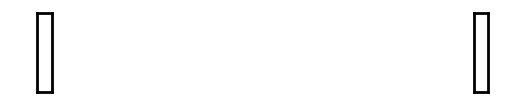

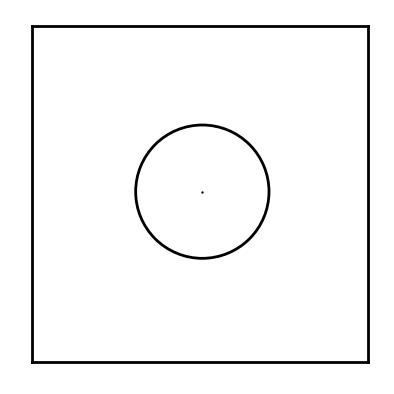

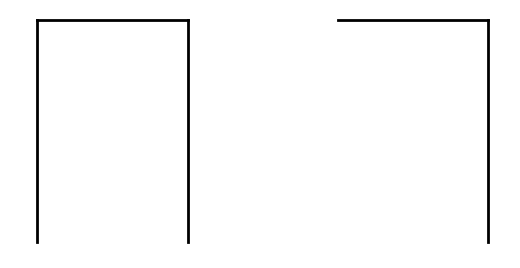

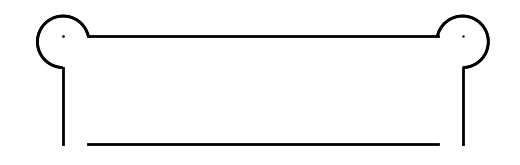

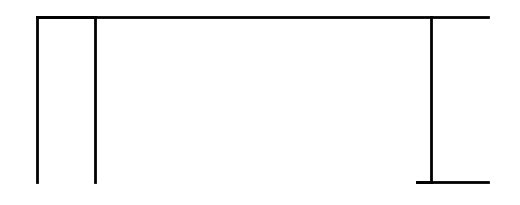

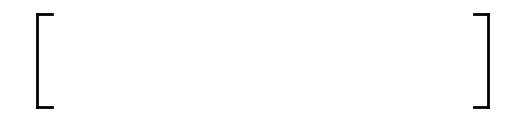

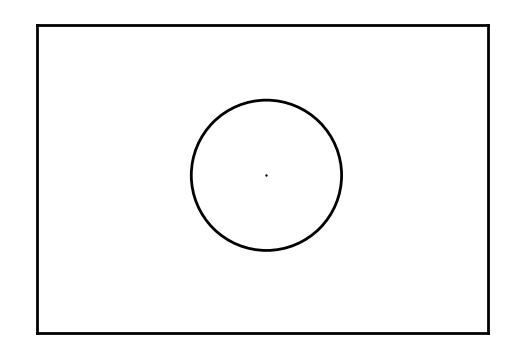

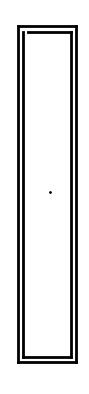

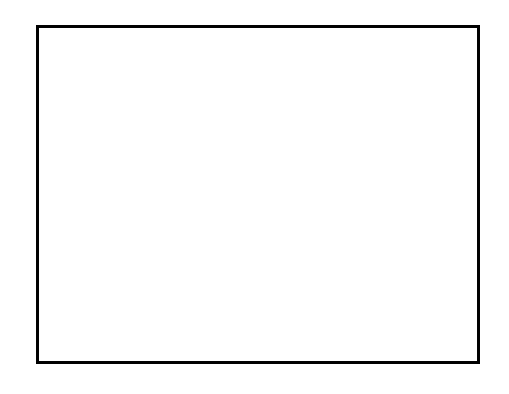

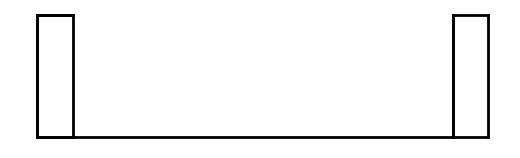

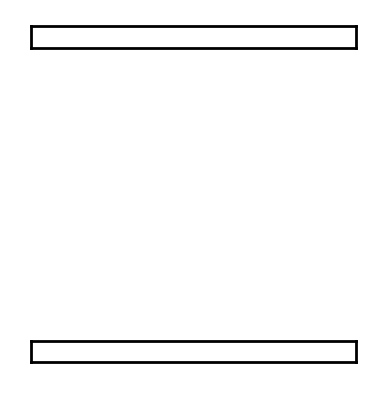

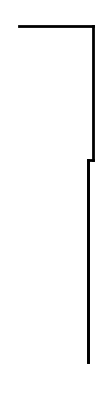

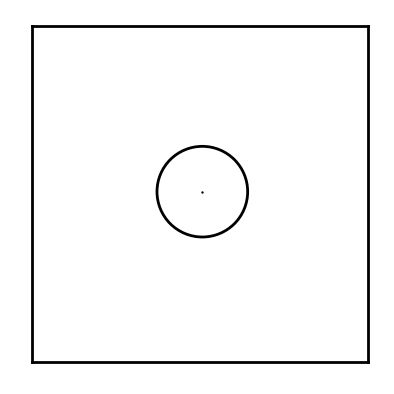

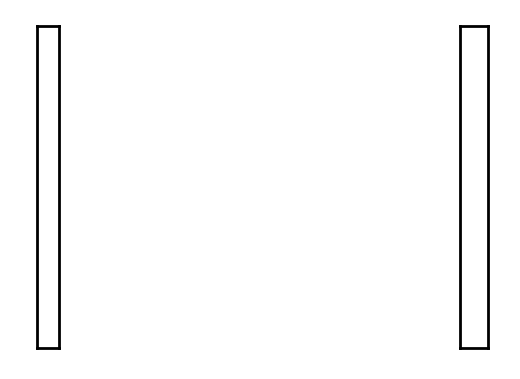

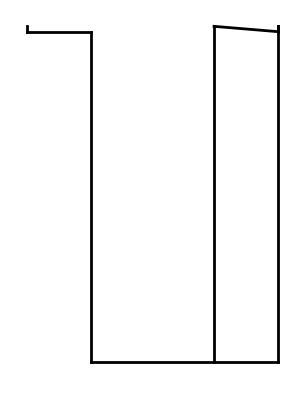

In [16]:
for i in range(cfg.num_samples):
    if sketches[i] is not None:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        datalib.render_sketch(sketches[i], ax)
        plt.savefig(f"evaluation_outputs/vitruvion2_samples/vitr{i}.png")

# FID Calculation

In [3]:
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split, TensorDataset
from tqdm import tqdm

nodes = torch.load("data/processed/nodes2.pt")
train_set, validate_set, test_set = random_split(dataset = nodes, lengths = [0.9, 0.05, 0.05], generator = torch.Generator().manual_seed(4))

In [4]:
import torch
import numpy as np
from torchmetrics.image import (
    PeakSignalNoiseRatio,
    StructuralSimilarityIndexMeasure,
    LearnedPerceptualImagePatchSimilarity
)
from torchmetrics.image.fid import FrechetInceptionDistance


In [5]:
class ImageEvaluator:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        
        # Initialize metrics
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)
        self.lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex').to(device)
        self.fid = FrechetInceptionDistance(feature=2048).dtype(torch.float64).to(device)
        
    def calculate_psnr(self, generated, real):
        """Calculate Peak Signal-to-Noise Ratio"""
        return self.psnr(generated, real)
    
    def calculate_ssim(self, generated, real):
        """Calculate Structural Similarity Index"""
        return self.ssim(generated, real)
    
    def calculate_lpips(self, generated, real):
        """Calculate LPIPS perceptual similarity"""
        return self.lpips(generated, real)
    
    def calculate_fid(self, real_images, fake_images):
        """Calculate FID score"""
        # Reset FID calculation
        self.fid.reset()
        
        # Update with real and fake images
        self.fid.update(real_images, real=True)
        self.fid.update(fake_images, real=False)
        
        # Compute FID
        return self.fid.compute()


In [6]:
# If your images are from matplotlib figures
def figure_to_tensor(figure):
    # Convert matplotlib figure to numpy array
    figure.canvas.draw()
    img_array = np.frombuffer(figure.canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(figure.canvas.get_width_height()[::-1] + (3,))
    
    # Convert to torch tensor and normalize to [0, 1]
    img_tensor = torch.from_numpy(img_array).float() / 255.0
    
    # Add batch dimension and rearrange to (B, C, H, W)
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
    return img_tensor.clone()

In [11]:
indices = torch.randint(0, nodes.size(0), (16,))
samples = nodes[indices]

In [14]:
for i, sample in enumerate(samples):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')

    datalib.render_sketch(nodes_to_sketch(sample), ax)
    plt.savefig(f"evaluation_outputs/dataset_samples/data_{i}.png")
    plt.close(fig)
    

In [1]:
import os
import torch
from torch import Tensor
import matplotlib.pyplot as plt
import math
from nodediff_model import GD3PM, CosineNoiseScheduler
from utils import ToNaive
from collections import OrderedDict
from torchmetrics.image.fid import FrechetInceptionDistance
import numpy as np
from torch.utils.data import DataLoader, random_split, TensorDataset
from tqdm import tqdm
os.chdir('SketchGraphs/')
import sketchgraphs.data as datalib
from sketchgraphs.data import flat_array
from sketchgraphs.data._entity import Point, Line, Circle, Arc, EntityType
from sketchgraphs.data.sketch import Sketch
os.chdir('../')

# Create a new OrderedDict without the 'module.' prefix
def DDP_to_normal(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # Remove 'module.'
        new_state_dict[name] = v

    return new_state_dict

# Freeze model parameters
def freeze_model(model):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

# If your images are from matplotlib figures
def figure_to_tensor(figure):
    # Convert matplotlib figure to numpy array
    figure.canvas.draw()
    img_array = np.frombuffer(figure.canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(figure.canvas.get_width_height()[::-1] + (3,))
    
    img_tensor = torch.from_numpy(img_array)
    
    # Add batch dimension and rearrange to (B, C, H, W)
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).clone()
    plt.close(figure)
    return img_tensor

def nodes_to_sketch(nodes : Tensor):
    sketch = Sketch()
    # Add entities
    for idx in range(len(nodes)):
        entity = nodes[idx]
        isConstructible = bool(entity[0].item() >= 0.5)
        match torch.argmax(entity[1:6]):
            case 0:
                # Create Line
                id = str(idx + 1)
                pnt = entity[6:8]
                startParam = 0
                dir = (entity[8:10] - entity[6:8]) / torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                endParam = torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                line = Line(entityId = id,
                            isConstruction = isConstructible, 
                            pntX = pnt[0].item(), 
                            pntY = pnt[1].item(), 
                            dirX = dir[0].item(), 
                            dirY = dir[1].item(), 
                            startParam = startParam, 
                            endParam = endParam.item()
                           );
                sketch.entities[id] = line
            case 1:
                # Create Circle
                id = str(idx + 1)
                center = entity[10:12]
                radius = entity[12]
                circle = Circle(entityId = id, 
                              isConstruction = isConstructible, 
                              xCenter = center[0].item(), 
                              yCenter = center[1].item(), 
                              xDir = 1, 
                              yDir = 0, 
                              radius = radius.item(), 
                              clockwise = False
                             );
                sketch.entities[id] = circle
            case 2: 
                # Create Arc
                id = str(idx + 1)
                center = entity[13:15]
                radius = entity[15]
                startParam = entity[16] * (2*math.pi)
                endParam = entity[17] * (2*math.pi)
                arc = Arc(entityId = id, 
                          isConstruction = isConstructible, 
                          xCenter = center[0].item(), 
                          yCenter = center[1].item(), 
                          xDir = 1, 
                          yDir = 0,
                          radius = radius.item(), 
                          startParam = startParam.item(),
                          endParam = endParam.item(), 
                          clockwise = False
                         );
                sketch.entities[id] = arc
            case 3:
                # Create Point
                id = str(idx + 1)
                x = entity[18]
                y = entity[19]
                point = Point(entityId = id, 
                              isConstruction = isConstructible,
                              x = x.item(),
                              y = y.item()
                             );
                sketch.entities[id] = point
            case _:
                continue
    return sketch

In [2]:
# real_imgs = []
# tqdm(test_set)
# for prims in tqdm(test_set):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, aspect='equal')

#     datalib.render_sketch(nodes_to_sketch(prims), ax)
#     img_tensor = figure_to_tensor(fig)
#     plt.close(fig)

#     real_imgs.append(img_tensor)
with torch.no_grad():
    GPU = 0
    nodes = torch.load("data/processed/nodes2.pt")
    train_set, validate_set, test_set = random_split(dataset = nodes, lengths = [0.9, 0.05, 0.05], generator = torch.Generator().manual_seed(4))

    # figure_to_tensor(datalib.render_sketch(nodes_to_sketch(nodes[0]))).shape

    diff_model = GD3PM(GPU)
    state_dict = torch.load("checkpoint_nodediff_ddp_adam_nopos_32layers_512nodedim_512condim_8heads_2000denoisingsteps.pth", map_location = {'cuda:%d' % 0: 'cuda:%d' % GPU})["model"]
    diff_model.load_state_dict(DDP_to_normal(state_dict))
    freeze_model(diff_model)

    real_features = torch.zeros(10_000, 2048)
    fake_features = torch.zeros(10_000, 2048)
    fid = FrechetInceptionDistance(feature=2048).set_dtype(torch.float64).to(GPU)
    fid.reset()
    bs = 25
    test_loader = DataLoader(dataset = test_set[0:10_000], batch_size = bs)
    i = 0
    for batch in tqdm(test_loader):
        real_imgs = torch.vstack([figure_to_tensor(datalib.render_sketch(nodes_to_sketch(sample))) for sample in batch]).to(GPU)
        gens = ToNaive(diff_model.sample(batch.size(0))[...,1:])
        gen_imgs = torch.vstack([figure_to_tensor(datalib.render_sketch(nodes_to_sketch(sample))) for sample in gens]).to(GPU)

        start_idx = i * bs
        end_idx = start_idx + bs
        real_features[start_idx:end_idx] = fid.inception(real_imgs)
        fake_features[start_idx:end_idx] = fid.inception(gen_imgs)
        # fid.update(real_imgs, real = True)
        # fid.update(gen_imgs, real = False)
        i = i + 1

    # fid_score = fid.compute()
    # print(fid_score)


  0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_47087/3091659109.py:42: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  img_tensor = torch.from_numpy(img_array)
100%|██████████| 400/400 [5:36:19<00:00, 50.45s/it]  


In [5]:
# torch.save({"real": real_features, "fake": fake_features}, "diff_inception_features.pth")
# torch.save({"real": real_features, "fake": fake_features}, "vitruvion_inception_features.pth")
# torch.save({"real": real_features, "fake": fake_features}, "diff_nopos_inception_features.pth")
torch.save({"real": real_features, "fake": fake_features}, "diff_categorical_inception_features.pth")



In [3]:
import torch
import numpy as np
from scipy import linalg
from sklearn.metrics.pairwise import euclidean_distances

def calculate_fid(real_features, fake_features):
    # Calculate mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    
    # Calculate FID
    diff = mu1 - mu2
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return float(fid)

def calculate_precision_recall(real_features, fake_features, k=3, threshold=0.95):
    # Normalize features
    real_features = real_features / np.linalg.norm(real_features, axis=1, keepdims=True)
    fake_features = fake_features / np.linalg.norm(fake_features, axis=1, keepdims=True)
    
    # Calculate pairwise distances
    real_distances = euclidean_distances(real_features, real_features)
    fake_distances = euclidean_distances(fake_features, fake_features)
    
    # Get radii for each point (mean distance to k nearest neighbors)
    def get_kth_nearest(distances, k):
        # Sort distances for each point
        nearest = np.partition(distances, k+1, axis=1)[:, 1:k+1]
        return np.mean(nearest, axis=1)
    
    real_radii = get_kth_nearest(real_distances, k)
    fake_radii = get_kth_nearest(fake_distances, k)
    
    # Calculate cross distances
    cross_distances = euclidean_distances(real_features, fake_features)
    
    # Calculate precision and recall
    precision = np.mean(np.min(cross_distances / real_radii[:, None], axis=0) < threshold)
    recall = np.mean(np.min(cross_distances / fake_radii[None, :], axis=1) < threshold)
    
    return precision, recall

# Example usage
# Assuming your features are numpy arrays
fid_score = calculate_fid(real_features.cpu().numpy(), fake_features.cpu().numpy())
precision, recall = calculate_precision_recall(real_features.cpu().numpy(), fake_features.cpu().numpy())

print(f"FID Score: {fid_score:.2f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

/tmp/ipykernel_47087/2425818605.py:42: RuntimeWarning: divide by zero encountered in divide
  precision = np.mean(np.min(cross_distances / real_radii[:, None], axis=0) < threshold)


FID Score: 148.93
Precision: 0.117
Recall: 0.028


In [2]:
sequences = flat_array.load_dictionary_flat("../vitruvion/data/filtered.npy")['sequences']
generator = torch.Generator().manual_seed(4242424242)
perm = torch.randperm(len(sequences), generator=generator)

num_train_samples = int(math.ceil(len(sequences) * (1 - .025 - .05)))
num_test_samples = int(math.ceil(len(sequences) * .05))

if num_train_samples + num_test_samples > len(sequences):
    num_test_samples = len(sequences) - num_train_samples

num_valid_samples = len(sequences) - num_train_samples - num_test_samples

train_idx, valid_idx, test_idx = torch.split(perm, [num_train_samples, num_valid_samples, num_test_samples])

test_dataset = test_idx[0:10_000]

In [3]:
import sys
sys.path.insert(0, '../vitruvion/')
import img2cad.sampling_utils as vitr_utils
import sketchgraphs.data as datalib
import matplotlib.pyplot as plt

GPU = 0
real_features = torch.zeros(10_000, 2048)
fake_features = torch.zeros(10_000, 2048)
bs = 100


with torch.no_grad():
    fid = FrechetInceptionDistance(feature=2048).set_dtype(torch.float64).to(GPU)
    fid.reset()
    test_loader = DataLoader(dataset = test_dataset[0:10_000], batch_size = bs)
    i = 0
    for batch in tqdm(test_loader):
        real_imgs = torch.vstack([figure_to_tensor(datalib.render_sketch(datalib.sketch_from_sequence(sequences[idx.item()]))) for idx in batch]).to(GPU)
        # gens = ToNaive(diff_model.sample(batch.size(0))[...,1:])
        cfg = vitr_utils.PrimitivesSamplingConfig()
        cfg.model_checkpoint = "../vitruvion/models/epoch_19.ckpt"
        cfg.num_samples = bs
        sketches = vitr_utils.sample_primitives(cfg, device = GPU)    
        gen_imgs = torch.vstack([figure_to_tensor(datalib.render_sketch(sketch)) for sketch in sketches]).to(GPU)

        # fid.update(real_imgs, real = True)
        # fid.update(gen_imgs, real = False)
        start_idx = i * bs
        end_idx = start_idx + bs
        real_features[start_idx:end_idx] = fid.inception(real_imgs)
        fake_features[start_idx:end_idx] = fid.inception(gen_imgs)

        i = i + 1

    # fid_score = fid.compute()
    # print(fid_score)

/home/chereds/SketchGNN/../vitruvion/img2cad/pipeline/prerender_images.py:225: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name='conf')
/home/chereds/SketchGNN/../vitruvion/img2cad/pipeline/prerender_images.py:225: UserWarning: 
config_path is not specified in @hydra.main().
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/changes_to_hydra_main_config_path for more information.
  @hydra.main(config_name='conf')
/home/chereds/SketchGNN/../vitruvion/img2cad/evaluation/sample_constraints.py:241: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name='conf')
/home/chereds/SketchGNN/../vitruvion/img2cad/evaluation/sample_constraints.py:241: UserWarning: 
config_path is not specified in @hydra.main().
See https://hydra.cc/docs/1.2/upgrades/1.0_t

In [5]:
GPU = 0
sampler = Sampler(GPU)
vae = GVAE(GPU)

# Load the original saved file with DataParallel
sampler_state_dict = torch.load('checkpoints/model_checkpoint_sampler_ddp_Adam_depth_32_1.pth')
vae_state_dict = torch.load('checkpoints/model_checkpoint_gvae_ddp_Adam_mse-25_kld-.001_16layers16heads256hiddenencoder_16layers16heads256hiddendecoder_embedim1024_tempnodedim128_relu_after_node_layernorm.pth')
# vae_state_dict = torch.load('model_checkpoint_gvae_ddp_Adam_12enclayers_12declayers.pth')
# sharpener_state_dict = torch.load('model_checkpoint_sharpener_ddp_Adam_16tflayers.pth')


# Load the parameters into your model and freeze
sampler.load_state_dict(DDP_to_normal(sampler_state_dict))
vae.load_state_dict(DDP_to_normal(vae_state_dict))

freeze_model(sampler)
freeze_model(vae)

In [6]:
T = sampler.max_timestep
a_bar = torch.cos(0.5 * torch.pi * (torch.arange(0.0, 1.0, 1/(T + 1)) + .008) / 1.008) ** 2
a_bar = a_bar / a_bar[0]
a_bar = a_bar.to(GPU)

a = a_bar[1:] / a_bar[:-1]
a = torch.cat([a, torch.tensor([0.0]).to(GPU)])

sqrt_a = a.sqrt()
sqrt_a_bar = a_bar.sqrt().to(GPU)
sqrt_b_bar = (1 - a_bar).sqrt().to(GPU)

sqrt_post_var = torch.cat([torch.tensor([0.0]).to(GPU), (a_bar[:-1] / a_bar[1:] * (1 - a[1:]))]).sqrt()

def sample_latent(batch_size):
    sampled_latents = torch.randn((batch_size, 1024)).to(GPU)

    for i in reversed(range(1, sampler.max_timestep)):
        pred_latents = sampler(sampled_latents, torch.full(size = (batch_size,), fill_value = i).to(GPU))
      
        denoised_mean = (sqrt_a_bar[i - 1] * (1 - a[i]) * pred_latents + sqrt_a[i] * (1 - a_bar[i - 1]) * sampled_latents) / (1 - a_bar[i])
        if i > 1:
            sampled_latents = denoised_mean + sqrt_post_var[i] * torch.randn_like(denoised_mean)
        else:
            sampled_latents = denoised_mean
    
    return sampled_latents

In [7]:
with torch.no_grad():
    GPU = 0
    nodes = torch.load("data/processed/nodes2.pt")
    train_set, validate_set, test_set = random_split(dataset = nodes, lengths = [0.9, 0.05, 0.05], generator = torch.Generator().manual_seed(4))

    real_features = torch.zeros(10_000, 2048)
    fake_features = torch.zeros(10_000, 2048)
    fid = FrechetInceptionDistance(feature=2048).set_dtype(torch.float64).to(GPU)
    fid.reset()
    bs = 100
    test_loader = DataLoader(dataset = test_set[0:10_000], batch_size = bs)
    i = 0
    for batch in tqdm(test_loader):
        real_imgs = torch.vstack([figure_to_tensor(datalib.render_sketch(nodes_to_sketch(sample))) for sample in batch]).to(GPU)
        latents = sample_latent(bs)
        gens, _ = vae.decoder(latents)
        gen_imgs = torch.vstack([figure_to_tensor(datalib.render_sketch(nodes_to_sketch(sample))) for sample in gens]).to(GPU)

        start_idx = i * bs
        end_idx = start_idx + bs
        real_features[start_idx:end_idx] = fid.inception(real_imgs)
        fake_features[start_idx:end_idx] = fid.inception(gen_imgs)
        # fid.update(real_imgs, real = True)
        # fid.update(gen_imgs, real = False)
        i = i + 1

    # fid_score = fid.compute()
    # print(fid_score)


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_43539/3091659109.py:42: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  img_tensor = torch.from_numpy(img_array)
100%|██████████| 100/100 [29:06<00:00, 17.47s/it]


In [ ]:
# def visualize_tensor(img_tensor):
#     # Remove batch dimension and move channels to last dimension
#     img = img_tensor.squeeze(0).permute(1, 2, 0)
    
#     # Convert to numpy and clip values to valid range
#     img_np = img.cpu().numpy().clip(0, 1)
    
#     # Display using matplotlib
#     plt.figure(figsize=(8, 8))
#     plt.imshow(img_np)
#     plt.axis('off')
#     plt.show()

# tensor = figure_to_tensor(datalib.render_sketch(nodes_to_sketch(nodes[19])))
# print(tensor.shape)

# visualize_tensor(tensor)

In [ ]:
# Initialize evaluator
evaluator = ImageEvaluator()

# Assuming you have batches of images (B, C, H, W) in range [0, 1]
batch_size, channels, height, width = 32, 3, 256, 256

# Example with random tensors (replace with your actual images)
real_images = torch.rand(batch_size, channels, height, width).to(evaluator.device)
fake_images = torch.rand(batch_size, channels, height, width).to(evaluator.device)

# Calculate metrics
psnr_score = evaluator.calculate_psnr(fake_images, real_images)
ssim_score = evaluator.calculate_ssim(fake_images, real_images)
lpips_score = evaluator.calculate_lpips(fake_images, real_images)
fid_score = evaluator.calculate_fid(real_images, fake_images)

print(f"PSNR: {psnr_score:.2f}")
print(f"SSIM: {ssim_score:.2f}")
print(f"LPIPS: {lpips_score:.2f}")
print(f"FID: {fid_score:.2f}")
